In [22]:
import tables
import os
from astropy.stats import bayesian_blocks
from bb_exponential import ExponentialBlocks_Events
import matplotlib.pyplot as plt
from multiprocessing import Pool
from itertools import repeat
import numpy as np

filename = '/home/tirocinio/Codice/tirocinio/Dati/DL0/acquisizione_2023_01_27/rpg0/dl0/wf_runId_00293_configId_00000_2023-01-27T14_32_51.090204.h5'

class Reader:
    def get_data_list(self,filename,startIndex=0,endIndex=-1):
        '''get data from h5 file starting by startIndex and ending at endIndex
        '''
        data_list = []
        with tables.open_file(filename,mode='r') as h5file:
            group = h5file.get_node('/waveforms')
            if endIndex == -1:
                endIndex = group._g_getnchildren()
            for i,data in enumerate(group):
                if i >= startIndex:
                    arr = data[:,-1]
                    data_list.append(arr)
                if i>=endIndex-1:
                    break
            return data_list
    def _make_graph(self,t,x,actual_outdir,name):
        plt.step(t, x)
        flag = False
        N = sum(x)
        ncp_prior = ExponentialBlocks_Events().p0_prior(N)
        while not flag:  #se ci sono errori di tipo 'troppi blocchi' faccio un ricalcolo usando un ncp_prior più alto
            xcoords = bayesian_blocks(t,x,fitness=ExponentialBlocks_Events,ncp_prior=ncp_prior)
            blocks_lengths = xcoords[1:]-xcoords[:-1]    
            if np.count_nonzero(blocks_lengths == 2)>2: #se ci sono più blocchi di lunghezza 2, allora c'è un errore di tipo 'troppi blocchi'
                ncp_prior = ncp_prior + 100
            else:
                flag = True
        for xc in xcoords:
            plt.axvline(x=xc, color='grey', alpha=0.3)
        for i in range(len(xcoords)-1):
            edge_l = xcoords[i]
            edge_r = xcoords[i+1]
            params = ExponentialBlocks_Events(ncp_fun=(lambda N: ExponentialBlocks_Events().p0_prior(N)-100)).get_parameters(edge_l,edge_r,t,x)
            a = params['a']
            gamma = params['gamma']
            plot_t = np.linspace(edge_l,edge_r,1000)
            plot_x = gamma * np.exp(a*(plot_t - edge_r))
            plt.plot(plot_t,plot_x)
        plt.figtext(0.5,0.01,f'subgraph area: {sum(x)}')
        plt.savefig(actual_outdir+'/'+name)
        plt.clf()
    def process_file(self,filename,startIndex=0,endIndex=-1,outdir='outdir',num_workers=1):
        '''
        filename: str, path to a h5 file containing binned data
        startIndex: int, starting index of data to process
        endIndex: int, index of last data to process
        outdir: str, path of the folder where a folder named like filename will be created to contain
                     the graphs of processed data
        num_workes: int, number of threads to use to speed up processing time
        
        processes the file via bb_exponential,returns nothing and as a side effect creates a folder 
        with the same name as the filename inside outdir with all the graphs of the processed data
        '''
        actual_outdir=os.path.join(outdir,filename.split('/')[-1])
        if not os.path.exists(actual_outdir):
            os.makedirs(actual_outdir)
        data = self.get_data_list(filename,startIndex=startIndex,endIndex=endIndex)
        t = np.arange(0,1000)
        x_s = [x[1000:2000] for x in data]
        zipped_data = zip(repeat(t),x_s,repeat(actual_outdir),[str(i)+'.png' for i in np.arange(startIndex,endIndex)])
        with Pool(num_workers) as p:
            p.starmap(self._make_graph,zipped_data)
def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"La directory '{directory_path}' è stata creata.")

In [2]:
reader = Reader()
data = reader.get_data_list(filename,0,10)

In [23]:
Reader().process_file(filename,1377,1379,'outdir3',3)

/home/tirocinio/Codice/tirocinio/BBexponential/bb_exponential.py:69: RuntimeWarning: overflow encountered in exp
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/home/tirocinio/Codice/tirocinio/BBexponential/bb_exponential.py:69: RuntimeWarning: divide by zero encountered in log
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/home/tirocinio/Codice/tirocinio/BBexponential/bb_exponential.py:69: RuntimeWarning: overflow encountered in exp
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/home/tirocinio/Codice/tirocinio/BBexponential/bb_exponential.py:69: RuntimeWarning: divide by zero encountered in log
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/nix/store/6jkzp4k9flx42l3ka9n4zyp7x05gcgri-python3-3.10.13-env/lib/python3.10/site-packages/scipy/optimize/_zeros_py.py:467: RuntimeWarning: some failed to converge after 50 iterations
  warnings.warn(msg, RuntimeWarning)
/nix/store/6jkzp4k9flx42l3ka9n4zyp7x05gcgri-python3-3.10.13-env/lib/python3.10/si

In [11]:
len(data)

[0 1 2 3 4 5 6 7 8 9]


10

In [7]:
print(data[9])

[131 131 130 ... 137 131 131]


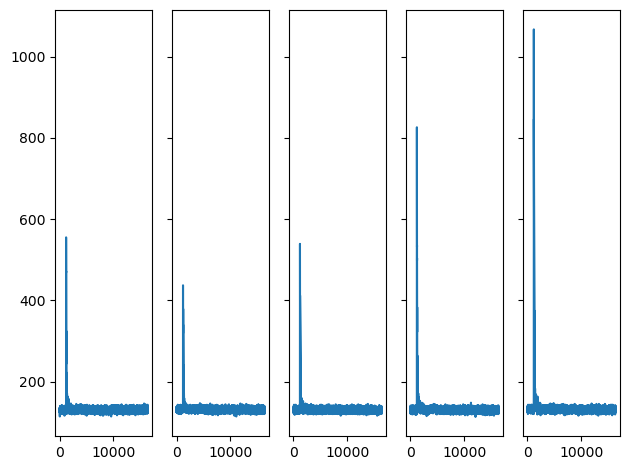

In [5]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 5, sharey=True, tight_layout=True)
for i in range(5):
    #print(len(data[i]))
    axs[i].plot(data[i])

1259742
Tempo di Calcolo: 16.216758012771606
Estremi: [  0.  195.5 524.5 999. ]
Blocco 0: a=0.0011002899883276666,gamma=152.13474962553795
Blocco 1: a=-0.00881400772607588,gamma=551.6230623375317
Blocco 2: a=-0.0025940880570829604,gamma=169.44929433087003


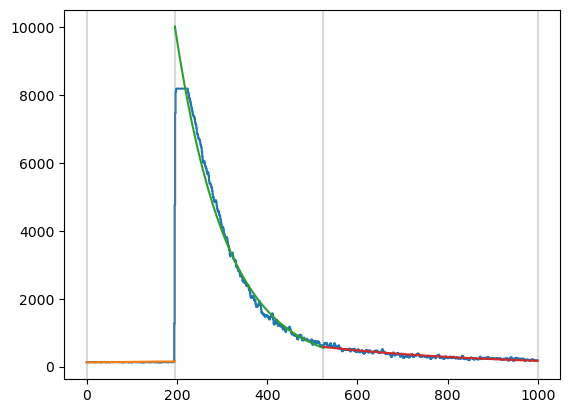

In [11]:
from astropy.stats import Events, bayesian_blocks
import numpy as np
from bb_exponential import ExponentialBlocks_Events, test_bb_exp
t=np.arange(0,1000)
x=data[37][1000:2000]
print(sum(x))
test_bb_exp(t,x,ExponentialBlocks_Events)

In [7]:
from astropy.stats import Events, bayesian_blocks
import numpy as np
from bb_exponential import ExponentialBlocks_Events, test_bb_exp

In [8]:
if False:
    t=np.arange(0,1000)
    for i in range(0,200):
        x=data[i][1000:2000]
        test_bb_exp(t,x,ExponentialBlocks_Events,save = True,name=f'outdir/wf_runId_00293_configId_00000_2023-01-27T14_32_51_090204_N_{sum(x)}_datanum_{i}.png')

In [9]:
N_list = [sum(data[i][1000:2000]) for i in range(len(data))]
estr_inf = min(N_list)
passo = (max(N_list)-min(N_list))*(1/100)
a = [[data[i] for i in range(len(N_list)) if estr_inf+n*passo<=N_list[i]<=estr_inf+(n+1)*passo] for n in range(100)]

In [10]:
print(estr_inf)
print(passo)
print(len(a))
print([len(b) for b in a])

131254
25450.850000000002
100
[6013, 2172, 747, 368, 243, 89, 63, 32, 22, 8, 12, 8, 11, 5, 9, 6, 9, 7, 5, 3, 7, 6, 6, 5, 9, 5, 2, 5, 2, 5, 9, 2, 6, 4, 4, 9, 3, 5, 3, 5, 6, 7, 6, 6, 7, 4, 2, 3, 0, 3, 0, 2, 2, 1, 2, 1, 0, 0, 2, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]


In [ ]:
from random import randint
t=np.arange(0,1000)
#for i in range(0,len(a[4])):
for i in range(100):
    index = randint(0,9999)
    print(index)
    x=data[index][1000:2000]
    print(sum(x))
    test_bb_exp(t,x,ExponentialBlocks_Events)